C:\Users\patum\AppData\Roaming\Python\Python311\site-packages\pymc\data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


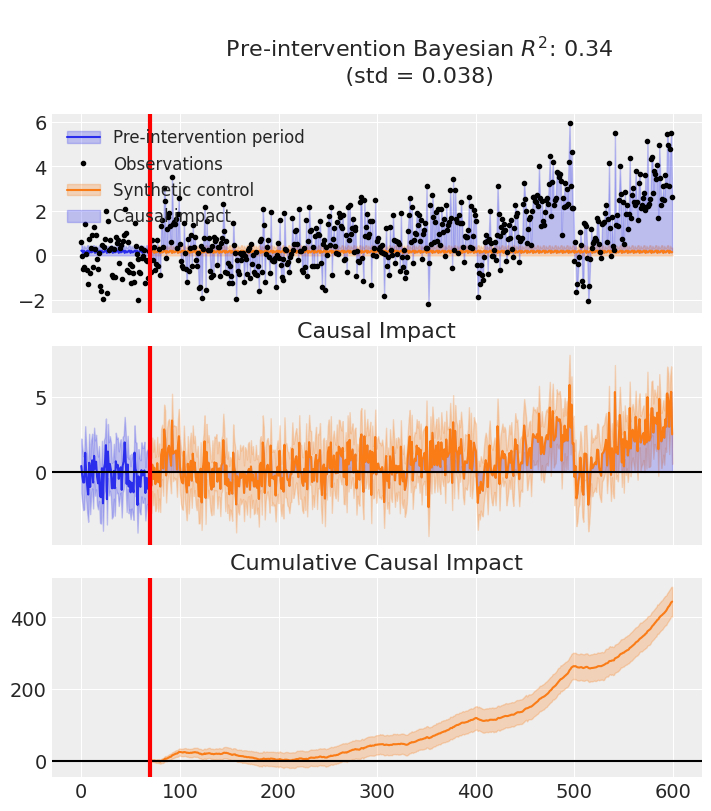

                  lval  op                rval  Estimate  Std. Err    z-value  \
0      teacher_quality   ~     policy_exposure  0.408732  0.062327   6.557838   
1           motivation   ~     policy_exposure  0.265240  0.062106   4.270731   
2           motivation   ~     teacher_quality  0.380668  0.031358  12.139343   
3   student_motivation   ~          motivation  1.000000         -          -   
4           study_time   ~          motivation  0.816819   0.04423  18.467678   
5          performance   ~     policy_exposure  0.233525  0.038607   6.048713   
6          performance   ~     teacher_quality  0.281613  0.024905  11.307349   
7          performance   ~          motivation  0.759975   0.04722  16.094476   
8           motivation  ~~          motivation  0.560036  0.050492  11.091644   
9      teacher_quality  ~~     teacher_quality  0.971158  0.043431   22.36068   
10         performance  ~~         performance  0.115771  0.018783   6.163619   
11  student_motivation  ~~  

In [3]:
import pandas as pd
import numpy as np
import causalpy as cp
from semopy import Model, inspector
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_time = 100
n_units = 5

# Generate control units
control_units = np.random.normal(0, 1, (n_time, n_units))
for i in range(n_units):
    control_units[:, i] += np.linspace(0, i, n_time)  # Add some trends

# Generate treated unit (similar to control_units[0] pre-treatment)
treated_unit = control_units[:, 0] + np.random.normal(0, 0.1, n_time)

# Add treatment effect after time point 70
treatment_time = 70
treated_unit[treatment_time:] += np.linspace(0, 2, n_time - treatment_time)

# Create DataFrame for synthetic control
df_synth = pd.DataFrame({
    'time': np.repeat(range(n_time), n_units + 1),
    'unit': np.tile(np.arange(n_units + 1), n_time),
    'value': np.concatenate([treated_unit] + [control_units[:, i] for i in range(n_units)])
})

df_synth['unit'] = pd.Categorical(df_synth['unit'])

# Run synthetic control analysis
result_synth = cp.pymc_experiments.SyntheticControl(
    df_synth,
    treatment_time,
    formula="value ~ 0 + C(unit)",
    model=cp.pymc_models.WeightedSumFitter(sample_kwargs={"random_seed": 42})
)

# Plot synthetic control results
fig, ax = result_synth.plot()
plt.show()

# Generate additional data for SEM analysis
n_students = 1000
policy_exposure = np.random.binomial(1, 0.5, n_students)
teacher_quality = np.random.normal(0, 1, n_students) + 0.5 * policy_exposure
student_motivation = np.random.normal(0, 1, n_students) + 0.3 * policy_exposure + 0.4 * teacher_quality
study_time = np.random.normal(0, 1, n_students) + 0.5 * student_motivation
performance = (0.3 * policy_exposure + 0.4 * teacher_quality + 
               0.3 * student_motivation + 0.2 * study_time + 
               np.random.normal(0, 0.5, n_students))

df_sem = pd.DataFrame({
    'policy_exposure': policy_exposure,
    'teacher_quality': teacher_quality,
    'student_motivation': student_motivation,
    'study_time': study_time,
    'performance': performance
})

# Define SEM model
sem_model = """
    # Measurement model
    motivation =~ student_motivation + study_time

    # Structural model
    teacher_quality ~ policy_exposure
    motivation ~ policy_exposure + teacher_quality
    performance ~ policy_exposure + teacher_quality + motivation
"""

# Fit SEM model
model = Model(sem_model)
results_sem = model.fit(df_sem)

# Print SEM results
print(inspector.inspect(model))